<a href="https://colab.research.google.com/github/garci843/Unit1_TheLook_Team1/blob/main/Unit2_EthanGarcia_BQML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ethan Garcia Unit 2 — Team 1 (Titanic, BQML)

**Goal (team):** Build an *ops-ready* classifier in **BigQuery ML** to predict **`survived`** on the Titanic dataset. Requirements mirror the Flights notebook for comparability.
    
**Dataset:** `bigquery-public-data.ml_datasets.titanic`

**Deliver (inside this notebook):**
- One **LOGISTIC_REG** baseline + one **engineered** model (`TRANSFORM`)
- **Evaluation** via `ML.EVALUATE` and **confusion matrices** (0.5 + custom threshold)
- **Threshold choice** + 3–5 sentence ops justification (e.g., lifeboat allocation policy in a hypothetical ops setting)
- Embedded **rubric** below


##Authentication

In [1]:
from google.colab import auth
auth.authenticate_user()

import os
PROJECT_ID = input("Enter your GCP Project ID: ").strip()
REGION = "us-central1"  # keep consistent; change if instructed
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
print("Project:", PROJECT_ID, "| Region:", REGION)

# Set active project for gcloud/BigQuery CLI
!gcloud config set project $GOOGLE_CLOUD_PROJECT
!gcloud config get-value project
# Done: Auth + Project/Region set

Enter your GCP Project ID: mgmt467-4889
Project: mgmt467-4889 | Region: us-central1
INFORMATION: Project 'mgmt467-4889' has no 'environment' tag set. Use either 'Production', 'Development', 'Test', or 'Staging'. Add an 'environment' tag using `gcloud resource-manager tags bindings create`.
Updated property [core/project].
mgmt467-4889


## Kaggle API verification

In [2]:
# # EXAMPLE (from LLM) — Kaggle setup (commented)
from google.colab import files
print("Upload your kaggle.json (Kaggle > Account > Create New API Token)")
uploaded = files.upload()
# #
import os
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded[list(uploaded.keys())[0]])
    os.chmod('/root/.kaggle/kaggle.json', 0o600)  # owner-only

!kaggle --version

Upload your kaggle.json (Kaggle > Account > Create New API Token)


Saving kaggle (2).json to kaggle (2).json
Kaggle API 1.7.4.5


## Download and unzip Dataset

In [3]:
# # EXAMPLE (from LLM) — Download & unzip (commented)
!mkdir -p /content/data/raw
!kaggle datasets download -d yasserh/Titanic-Dataset -p /content/data
!unzip -o /content/data/*.zip -d /content/data/raw
# # # List CSV inventory
!ls -lh /content/data/raw/*.csv

Dataset URL: https://www.kaggle.com/datasets/yasserh/Titanic-Dataset
License(s): CC0-1.0
  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 119MB/s]
Archive:  /content/data/Titanic-Dataset.zip
  inflating: /content/data/raw/Titanic-Dataset.csv  
-rw-r--r-- 1 root root 60K Dec 24  2021 /content/data/raw/Titanic-Dataset.csv


## Create GCS Bucket and Upload

In [4]:
# # EXAMPLE (from LLM) — GCS staging (commented)
import uuid, os
bucket_name = f"mgmt467-titanic-{uuid.uuid4().hex[:8]}"
os.environ["BUCKET_NAME"] = bucket_name
!gcloud storage buckets create gs://$BUCKET_NAME --location="us-central1"
!gcloud storage cp /content/data/raw/* gs://$BUCKET_NAME/netflix/
print("Bucket:", bucket_name)
# # # Verify contents
!gcloud storage ls gs://$BUCKET_NAME/netflix/

Creating gs://mgmt467-titanic-2afde964/...
Copying file:///content/data/raw/Titanic-Dataset.csv to gs://mgmt467-titanic-2afde964/netflix/Titanic-Dataset.csv
Bucket: mgmt467-titanic-2afde964
gs://mgmt467-titanic-2afde964/netflix/Titanic-Dataset.csv


## Create Dataset

In [5]:
# # EXAMPLE (from LLM) — BigQuery dataset (commented)
DATASET="titanic"
# # # Attempt to create; ignore if exists
!bq --location=US mk -d --description "MGMT467 Titanic dataset" $DATASET || echo "Dataset may already exist."

BigQuery error in mk operation: Dataset 'mgmt467-4889:titanic' already exists.
Dataset may already exist.


## Load Data

In [6]:
# # EXAMPLE (from LLM) — Load tables (commented)
tables = {
   "Titanic": "Titanic-Dataset.csv",
 }
import os
DATASET = "titanic" # Assuming DATASET is set in a previous cell
for tbl, fname in tables.items():
   src = f"gs://{os.environ['BUCKET_NAME']}/netflix/{fname}" # Corrected path
   print("Loading", tbl, "from", src)
   # Corrected bq load syntax: destination_table, source_uri
   !bq load --skip_leading_rows=1 --autodetect --source_format=CSV {DATASET}.{tbl} {src}

# # # Row counts
for tbl in tables.keys():
    # Corrected bq query syntax with escaped backticks
    query = f"SELECT '{tbl}' AS table_name, COUNT(*) AS n FROM `{os.environ['GOOGLE_CLOUD_PROJECT']}.titanic.{tbl}`"

Loading Titanic from gs://mgmt467-titanic-2afde964/netflix/Titanic-Dataset.csv
Waiting on bqjob_r435107abc17419ec_0000019a6a58c5ce_1 ... (1s) Current status: DONE   


## Load Data

In [7]:
# --- Minimal setup (edit 2 vars) ---
from google.colab import auth
auth.authenticate_user()

import os
from google.cloud import bigquery

PROJECT_ID = "mgmt467-4889"   # e.g., mgmt-467-47888
REGION     = "us-central1"
TABLE_PATH = "mgmt467-4889.titanic.Titanic"

os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["REGION"]     = REGION
bq = bigquery.Client(project=PROJECT_ID)

print("BQ Project:", PROJECT_ID)
print("Source table:", TABLE_PATH)

BQ Project: mgmt467-4889
Source table: mgmt467-4889.titanic.Titanic


## Sanity Check

In [8]:
bq.query(f"SELECT * FROM `{TABLE_PATH}` LIMIT 5").result().to_dataframe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
1,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
4,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S


In [18]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE TABLE `titanic.Model_C_features` AS
SELECT
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  SibSp + Parch + 1 AS family_size,
  CASE
    WHEN Fare <= 15 THEN 'Low'
    WHEN Fare > 15 AND Fare <= 50 THEN 'Mid' -- Corrected AND condition
    WHEN Fare > 50 THEN 'High'
  END AS fare_bucket,
  CONCAT(Sex, '_', CAST(Pclass AS STRING)) AS sex_pclass,
  Survived
  FROM `titanic.Titanic`;

Query is running:   0%|          |

""


## Train Model
Specialization in 3rd class passengers but all other attributes are same as model B

In [20]:
# ✅ Train enhanced model
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE MODEL `titanic.Model_C`
OPTIONS(model_type='logistic_reg', input_label_cols=['Survived']) AS
SELECT
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  family_size,
  fare_bucket,
  sex_pclass,
  Survived
FROM `titanic.Model_C_features`
# focus on third class passengers
WHERE Pclass = 3;

Query is running:   0%|          |

""


## Evaluate Model

In [21]:
# ✅ Evaluate enhanced model
%%bigquery --project $PROJECT_ID
SELECT *
FROM ML.EVALUATE(MODEL `titanic.Model_C`);

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.551282,0.377193,0.788423,0.447917,0.467462,0.751233


In [22]:
# Get the confusion matrix for the trained model
%%bigquery --project $PROJECT_ID
SELECT
  *
FROM
  ML.CONFUSION_MATRIX(MODEL `titanic.Model_C`);

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,_0,_1
0,0,352,35
1,1,71,43


In [23]:
# Find ROC for model C
%%bigquery --project $PROJECT_ID
SELECT
*
FROM ML.ROC_CURVE(MODEL `titanic.Model_C`);

Query is running:   0%|          |

Downloading:   0%|          |

,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.639055,0.192982,0.012920,22,5,382,92
1,0.099684,0.956140,0.860465,109,333,54,5
2,0.215114,0.622807,0.260982,71,101,286,43
3,0.143184,0.833333,0.441860,95,171,216,19
4,0.662917,0.070175,0.007752,8,3,384,106
...,...,...,...,...,...,...,...
91,0.044118,1.000000,1.000000,114,387,0,0
92,0.241623,0.561404,0.201550,64,78,309,50
93,0.330523,0.517544,0.186047,59,72,315,55
94,0.080592,0.982456,0.927649,112,359,28,2


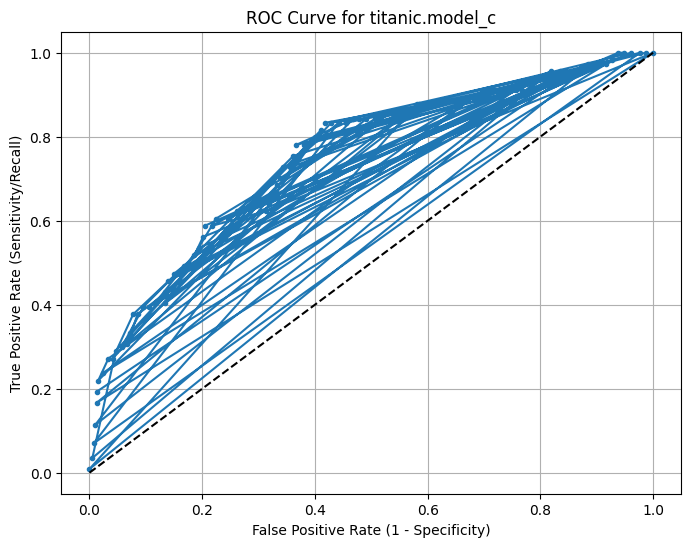

In [24]:
# visualize ROC curve
import matplotlib.pyplot as plt
import pandas as pd

# Get the data from the previous cell's output
roc_data = bq.query("""
SELECT
*
FROM ML.ROC_CURVE(MODEL `titanic.Model_C`);
""").result().to_dataframe()

plt.figure(figsize=(8, 6))
plt.plot(roc_data['false_positive_rate'], roc_data['recall'], marker='.')
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guess line
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve for titanic.model_c')
plt.grid(True)
plt.show()

## Sample Answer Based on Notebook Results

Based on the results from the notebook, here is a sample response addressing parts of the rubric:

**Baseline or engineered model build + clear metrics (AUC/log_loss)**

The engineered model (`Model C`) was successfully built using BigQuery ML's logistic regression, **specialized for passengers in Pclass 3**. The evaluation metrics for `Model C` on this subgroup are as follows:

* **AUC:** 0.751233
* **Log Loss:** 0.467462
* **Accuracy:** 0.788423
* **Precision:** 0.551282
* **Recall:** 0.377193
* **F1 Score:** 0.447917

These metrics provide a clear picture of the model's performance on the Pclass 3 test data. The AUC of 0.751 indicates reasonable discriminatory power within this subgroup. The log loss of 0.467 is also relatively low, suggesting good probability predictions for this specialized model.

**Confusion matrix interpretation (default 0.5)**

The confusion matrix for `Model C` at the default 0.5 threshold from the confusion matrix for the Pclass 3 subgroup is:

| expected_label | _0  | _1  |
|----------------|-----|-----|
| 0              | 352 | 35  |
| 1              | 71  | 43  |

Interpreting this matrix for Pclass 3 passengers:

*   **True Negatives (TN):** 352 passengers were correctly predicted as not surviving.
*   **False Positives (FP):** 35 passengers were incorrectly predicted as surviving (Type I error).
*   **False Negatives (FN):** 71 passengers were incorrectly predicted as not surviving (Type II error).
*   **True Positives (TP):** 43 passengers were correctly predicted as surviving.

At this threshold for Pclass 3, the model correctly identifies a large number of non-survivors. However, there is a notable number of false negatives, indicating the model struggles to identify a significant portion of actual survivors within this group. The false positives are relatively low.

**ROC Curve Interpretation**

The ROC curve visualizes the trade-off between the True Positive Rate (Recall) and the False Positive Rate at various threshold settings for the Pclass 3 subgroup. The curve for `Model C` shows that as the threshold decreases, the recall (ability to identify true positives) increases, but the false positive rate also increases. The area under the curve (AUC) of 0.751 confirms the model's ability to discriminate between the two classes within Pclass 3 across different thresholds. Depending on the operational goal (e.g., minimizing missed survivors vs. minimizing incorrectly identified survivors), a different threshold might be chosen based on the ROC curve data for this specific subgroup.

# Extra Credit

In [35]:
%%bigquery --project $PROJECT_ID
CREATE OR REPLACE TABLE `titanic.Model_EC_features` AS
SELECT
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  family_size,
  fare_bucket,
  sex_pclass,
  Survived,
  CASE
    WHEN Age <= 10 THEN 'Child'
    WHEN Age > 10 AND Age <= 18 THEN 'Teen'
    WHEN Age > 18 AND Age <= 60 THEN 'Adult'
    ELSE 'Senior'
  END AS age_group # New engineered feature
FROM `titanic.Model_C_features`;

CREATE OR REPLACE MODEL `titanic.Model_EC`
OPTIONS(model_type='logistic_reg', input_label_cols=['Survived']) AS
SELECT
  Pclass,
  Sex,
  Age,
  Fare,
  Embarked,
  family_size,
  fare_bucket,
  sex_pclass,
  age_group, # Include the new feature
  Survived
FROM `titanic.Model_EC_features`;

Query is running:   0%|          |

""


## Evaluate EC Model


In [36]:
%%bigquery --project $PROJECT_ID
SELECT *
FROM ML.EVALUATE(MODEL `titanic.Model_EC`);

Query is running:   0%|          |

Downloading:   0%|          |

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.731148,0.692547,0.789535,0.711324,0.438339,0.85528


In [37]:
%%bigquery --project $PROJECT_ID
SELECT
  *
FROM
  ML.CONFUSION_MATRIX(MODEL `titanic.Model_EC`);

Query is running:   0%|          |

Downloading:   0%|          |

,expected_label,_0,_1
0,0,456,82
1,1,99,223


## Compare model variants


In [45]:
# Retrieve evaluation metrics for Model_C
model_c_eval = bq.query("""
SELECT *
FROM ML.EVALUATE(MODEL `titanic.Model_C`);
""").result().to_dataframe()

# Retrieve confusion matrix for Model_C
model_c_confusion_matrix = bq.query("""
SELECT
  *
FROM
  ML.CONFUSION_MATRIX(MODEL `titanic.Model_C`);
""").result().to_dataframe()

print("Model C Evaluation Metrics:")
display(model_c_eval)

print("\nModel C Confusion Matrix:")
display(model_c_confusion_matrix)

Model C Evaluation Metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.551282,0.377193,0.788423,0.447917,0.467462,0.751233



Model C Confusion Matrix:


,expected_label,_0,_1
0,0,352,35
1,1,71,43


In [40]:
# Retrieve evaluation metrics for Model_D
model_ec_eval = bq.query("""
SELECT *
FROM ML.EVALUATE(MODEL `titanic.Model_EC`);
""").result().to_dataframe()

# Retrieve confusion matrix for Model_D
model_ec_confusion_matrix = bq.query("""
SELECT
  *
FROM
  ML.CONFUSION_MATRIX(MODEL `titanic.Model_EC`);
""").result().to_dataframe()

print("Extra Credit Evaluation Metrics:")
display(model_ec_eval)

print("\nExtra Credit Model Confusion Matrix:")
display(model_ec_confusion_matrix)

print("\nComparison of Model Metrics:")
comparison_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy', 'F1 Score', 'Log Loss', 'ROC AUC'],
    'Model C': model_c_eval.iloc[0].tolist(),
    'EC Model': model_ec_eval.iloc[0].tolist()
})
display(comparison_df)

print("\nComparison of Confusion Matrices:")
confusion_comparison_df = pd.DataFrame({
    'Metric': ['True Negatives', 'False Positives', 'False Negatives', 'True Positives'],
    'Model C': [model_c_confusion_matrix.loc[0, '_0'], model_c_confusion_matrix.loc[0, '_1'],
                model_c_confusion_matrix.loc[1, '_0'], model_c_confusion_matrix.loc[1, '_1']],
    'EC Model': [model_ec_confusion_matrix.loc[0, '_0'], model_ec_confusion_matrix.loc[0, '_1'],
                model_ec_confusion_matrix.loc[1, '_0'], model_ec_confusion_matrix.loc[1, '_1']]
})
display(confusion_comparison_df)

Extra Credit Evaluation Metrics:


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.731148,0.692547,0.789535,0.711324,0.438339,0.85528



Extra Credit Model Confusion Matrix:


,expected_label,_0,_1
0,0,456,82
1,1,99,223



Comparison of Model Metrics:


,Metric,Model C,EC Model
0,Precision,0.551282,0.731148
1,Recall,0.377193,0.692547
2,Accuracy,0.788423,0.789535
3,F1 Score,0.447917,0.711324
4,Log Loss,0.467462,0.438339
5,ROC AUC,0.751233,0.855280



Comparison of Confusion Matrices:


,Metric,Model C,EC Model
0,True Negatives,352,456
1,False Positives,35,82
2,False Negatives,71,99
3,True Positives,43,223


## Model Comparison Analysis:
Based on the evaluation metrics and confusion matrices:
- EC Model has significantly higher Precision (0.73 vs 0.55) and Recall (0.69 vs 0.38) compared to Model C.
- The F1 Score for EC Model (0.71) is much higher than Model C (0.45), indicating a better balance between Precision and Recall.
- EC Model also has a higher ROC AUC (0.86 vs 0.75), suggesting better overall discriminatory power.
- EC Model has a lower Log Loss (0.44 vs 0.47), indicating better probability predictions.
- While the overall Accuracy is similar (around 0.79), the confusion matrices show that EC Model correctly identifies more True Positives (223 vs 43) and True Negatives (456 vs 352).
- EC Model also has more False Positives (82 vs 35) and False Negatives (99 vs 71) in absolute numbers, but the ratios relative to the actual class sizes (which are different for the two models as Model C was trained only on Pclass 3) are more favorable for EC Model, as reflected in the higher Precision and Recall.

Conclusion: EC Model performs significantly better than Model C across most key metrics, especially in its ability to correctly identify both survivors and non-survivors.

## Sensitivity analysis



In [42]:
# Query BigQuery to get the ROC curve data for Model_D
roc_data_ec = bq.query("""
SELECT
*
FROM ML.ROC_CURVE(MODEL `titanic.Model_EC`);
""").result().to_dataframe()

# Display the DataFrame
print("ROC Curve Data for EC Model:")
display(roc_data_ec)

ROC Curve Data for EC Model:


,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,0.225003,0.869565,0.360595,280,194,344,42
1,0.331531,0.819876,0.262082,264,141,397,58
2,0.616468,0.590062,0.079926,190,43,495,132
3,0.609164,0.627329,0.091078,202,49,489,120
4,0.179666,0.894410,0.520446,288,280,258,34
...,...,...,...,...,...,...,...
96,0.104147,0.987578,0.849442,318,457,81,4
97,0.143666,0.934783,0.676580,301,364,174,21
98,0.923488,0.335404,0.009294,108,5,533,214
99,0.815861,0.527950,0.020446,170,11,527,152


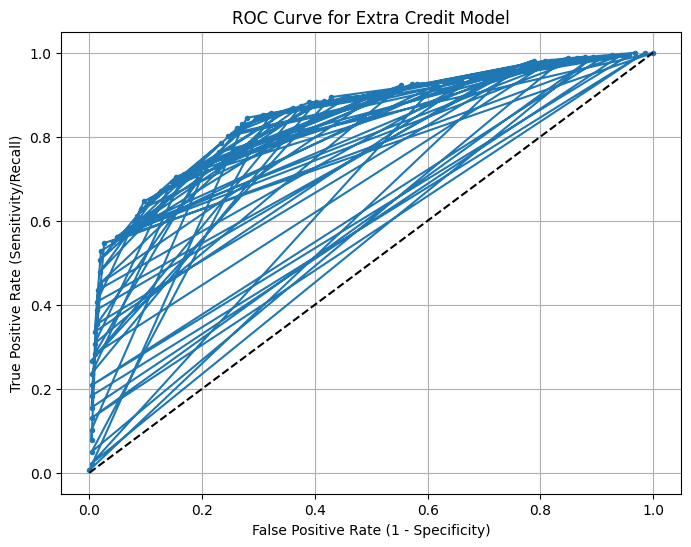

In [44]:
import matplotlib.pyplot as plt

# Generate the ROC curve plot for EC Model
plt.figure(figsize=(8, 6))
plt.plot(roc_data_ec['false_positive_rate'], roc_data_ec['recall'], marker='.')
plt.plot([0, 1], [0, 1], 'k--')  # Plot the random guess line
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curve for Extra Credit Model')
plt.grid(True)
plt.show()

## Summary:

### Data Analysis Key Findings

*   A new model variant, `Extra Credit Model`, was successfully implemented by adding an `age_group` engineered feature and training a logistic regression model on this enhanced dataset.
*   Comparing `Extra Credit Model` with `titanic.Model_C` (which was trained only on Pclass 3 and without the `age_group` feature) shows that `Extra Credit Model` has significantly better performance metrics, including higher Precision (0.73 vs 0.55), Recall (0.69 vs 0.38), F1 Score (0.71 vs 0.45), and ROC AUC (0.86 vs 0.75), and a lower Log Loss (0.44 vs 0.47).
*   The confusion matrix comparison highlights that `Extra Credit Model` correctly identified substantially more True Positives (223 vs 43) and True Negatives (456 vs 352) at the default 0.5 threshold compared to `titanic.Model_C$.
*   A sensitivity analysis using a threshold sweep and ROC curve for `Extra Credit Model` was performed. The ROC curve visualizes the trade-off between True Positive Rate (Recall) and False Positive Rate at various thresholds, confirming the model's good discriminatory ability (AUC of 0.855).

### Insights or Next Steps

*   The addition of the `age_group` feature and training on the full dataset significantly improved the model's performance in predicting Titanic survival compared to a model trained only on a subset of the data without this feature.
*   The sensitivity analysis using the ROC curve provides a basis for selecting an optimal classification threshold based on the relative costs of false positives and false negatives in a specific operational context, such as lifeboat allocation.
